In [29]:
import time

import pandas as pd
import numpy as np

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import cross_validate, KFold, train_test_split
from sklearn.metrics import make_scorer, mean_squared_error
from sklearn.ensemble import AdaBoostRegressor, BaggingRegressor, ExtraTreesRegressor, GradientBoostingRegressor, RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor, ExtraTreeRegressor
from sklearn.linear_model import ElasticNet, HuberRegressor, Lasso, LinearRegression, OrthogonalMatchingPursuit, Ridge, RANSACRegressor, TheilSenRegressor
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.cross_decomposition import PLSRegression
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor

from warnings import filterwarnings
filterwarnings('ignore')

In [30]:
df_train_copy = pd.read_csv('../Datasets/preprocessed_datasets/final_selected_features_data_copy.csv')
df_test = pd.read_csv('../Datasets/preprocessed_datasets/final_selected_features_df_test.csv')

In [31]:
features = [col for col in df_train_copy.columns if col != "SalePrice"]
print(features)

['OverallQual', 'GrLivArea', 'GarageCars', 'TotalBsmtSF', '1stFlrSF', 'GarageFinish', 'Fireplaces', 'OpenPorchSF', 'LotArea', 'CentralAir_Y', 'YearRemodAdd_Age', 'YearBuilt_Age']


In [32]:
X_train, X_val, y_train, y_val = train_test_split(df_train_copy[features], df_train_copy["SalePrice"], test_size = 0.2, random_state = 619)

In [33]:
# Define the regression models to evaluate
models = [
    # Ensemble Methods
    AdaBoostRegressor(),
    BaggingRegressor(),
    CatBoostRegressor(verbose=False),
    ExtraTreesRegressor(),
    GradientBoostingRegressor(),
    RandomForestRegressor(),
    XGBRegressor(),
    LGBMRegressor(verbose=0),
    
    # Tree Methods
    DecisionTreeRegressor(),
    ExtraTreeRegressor(),
    
    # Linear Methods
    ElasticNet(),
    HuberRegressor(),
    Lasso(),
    LinearRegression(),
    make_pipeline(PolynomialFeatures(degree=2), LinearRegression()),
    OrthogonalMatchingPursuit(),
    Ridge(),
    RANSACRegressor(),
    TheilSenRegressor(),
    
    # Gaussian Processes Methods
    GaussianProcessRegressor(),
    
    # Kernel Methods
    KernelRidge(),
    
    # Nearest Neighbors Methods
    KNeighborsRegressor(),
    
    # SVM Methods
    SVR(),
    
    # Neural Network Methods
    MLPRegressor(),
    
    # Cross-Decomposition Methods
    PLSRegression()
]

# Define columns for the comparison dataframe
compare_columns = ['Model', 'Mean Model Train RMSE', 'Mean Model Test RMSE', 'Lower Bound Model Test RMSE (Mean-3*STD)', 'Upper Bound Model Test RMSE (Mean+3*STD)', 'Mean Model Training Time', 'Total Model CrossValidation Time']
model_compare = pd.DataFrame(columns=compare_columns)

# Define RMSE scorer
rmse_scorer = make_scorer(mean_squared_error, squared=False)

# Splitting data for cross-validation using KFold splitting
kf = KFold(n_splits=10, shuffle=True, random_state=619)

# Adding Model Results row-wise in model_compare dataframe
index = 0
for model in models:
    # 
    print(f"Started Training Model: {model.__class__.__name__}...")

    # Model Name
    model_compare.loc[index, 'Model'] = model.__class__.__name__
    
    start_time = time.time()
    cv_results = cross_validate(model, df_train_copy[features], df_train_copy["SalePrice"], cv=kf, scoring=rmse_scorer, return_train_score=True)
    end_time = time.time()

    model_compare.loc[index, 'Mean Model Train RMSE'] = cv_results['train_score'].mean()
    model_compare.loc[index, 'Mean Model Test RMSE'] = cv_results['test_score'].mean()   

    # To check how much RMSE might vary
    model_compare.loc[index, 'Lower Bound Model Test RMSE (Mean-3*STD)'] = cv_results['test_score'].mean() - cv_results['test_score'].std()*3
    model_compare.loc[index, 'Upper Bound Model Test RMSE (Mean+3*STD)'] = cv_results['test_score'].mean() + cv_results['test_score'].std()*3

    model_compare.loc[index, 'Mean Model Training Time'] = cv_results['fit_time'].mean()
    model_compare.loc[index, 'Total Model CrossValidation Time'] = end_time - start_time
    
    print(f"Finished Training model: {model.__class__.__name__}")
    print(f"Time taken: {end_time - start_time:.2f} seconds\n\n")

    index += 1

# Print the model results in ascending order to get the best performing model (lower RMSE is better)
model_compare.sort_values('Mean Model Test RMSE', ascending=True, inplace=True)
print(model_compare)

Started Training Model: AdaBoostRegressor...
Finished Training model: AdaBoostRegressor
Time taken: 2.08 seconds


Started Training Model: BaggingRegressor...
Finished Training model: BaggingRegressor
Time taken: 1.17 seconds


Started Training Model: CatBoostRegressor...
Finished Training model: CatBoostRegressor
Time taken: 26.39 seconds


Started Training Model: ExtraTreesRegressor...
Finished Training model: ExtraTreesRegressor
Time taken: 6.38 seconds


Started Training Model: GradientBoostingRegressor...
Finished Training model: GradientBoostingRegressor
Time taken: 3.12 seconds


Started Training Model: RandomForestRegressor...
Finished Training model: RandomForestRegressor
Time taken: 9.77 seconds


Started Training Model: XGBRegressor...
Finished Training model: XGBRegressor
Time taken: 4.14 seconds


Started Training Model: LGBMRegressor...
Finished Training model: LGBMRegressor
Time taken: 1.33 seconds


Started Training Model: DecisionTreeRegressor...
Finished Training mode

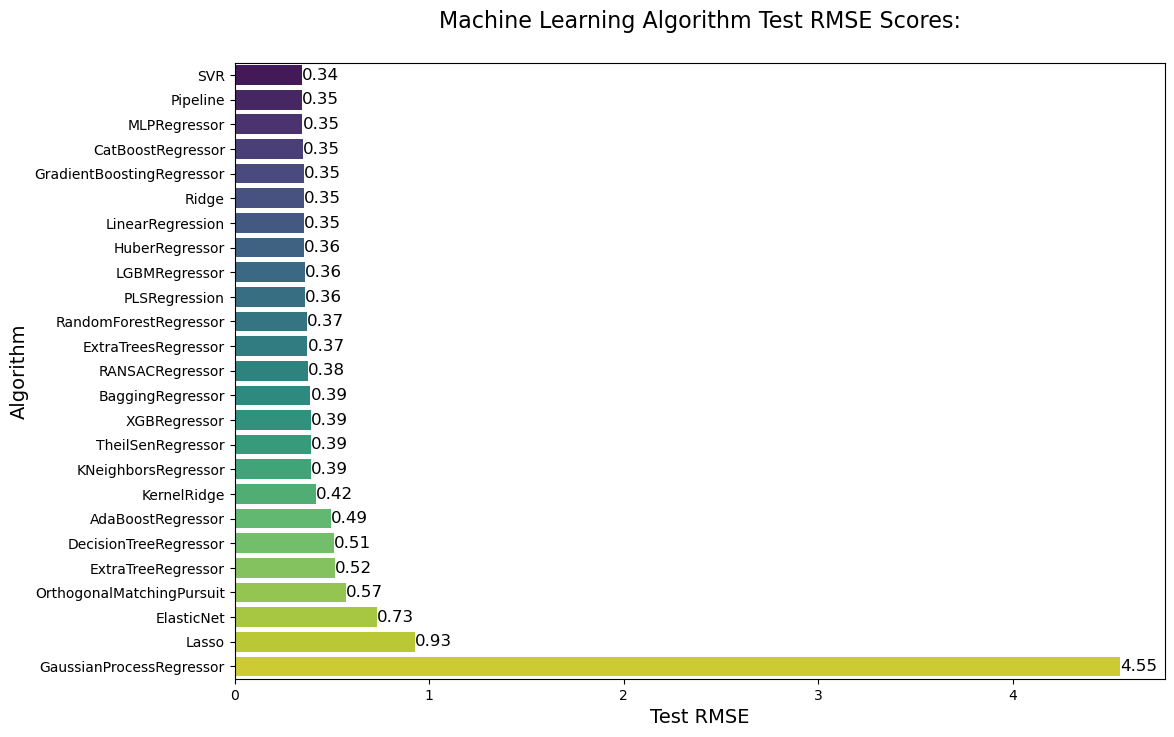

In [36]:
# Define a color palette
color_palette = sns.color_palette("viridis", n_colors=len(model_compare))

# Create a barplot
plt.figure(figsize=(12, 8))
ax = sns.barplot(x='Mean Model Test RMSE', y='Model', data=model_compare, palette=color_palette)

# Add title and labels
plt.title('Machine Learning Algorithm Test RMSE Scores:\n', fontsize=16)
plt.xlabel('Test RMSE', fontsize=14)
plt.ylabel('Algorithm', fontsize=14)

# Annotate each bar with the RMSE value
for container in ax.containers:
    for bar in container:
        width = bar.get_width()
        ax.text(width, bar.get_y() + bar.get_height()/2, f'{width:.2f}', 
                va='center', ha='left', fontsize=12, color='black')

# Show the plot
plt.show()